## ORGANS: Per-Capita Rates

This notebook contains analysis of per-capita rates for deaths from chronic liver disease, liver transplants, liver donations, and additions to the liver waitlist.

---

### Initialize environment

In [4]:
library(tidyverse)
library(lubridate)

In [5]:
root_path     <- here::here()
data_path     <- paste0(root_path, "/01_data")
analysis_path <- paste0(root_path, "/02_analysis")

In [6]:
setwd(data_path)

# 1) candidate => # of waitlist additions per state-year
candidate <- readRDS("clean/candidate_clean.rds")

# 2) transplant => # of transplants per state-year
transplant <- readRDS("clean/transplant_clean.rds")

# 3) cdcWonder => # of chronic liver disease deaths per state-year
cdcWonder <- readRDS("clean/cdc_wonder_clean.rds")

# 4) state_code_mapping => used for merging state between data sources
state_code_mapping <- read.csv("raw/00_misc/state_code_mapping_20221022.csv")

setwd(analysis_path)

---

### Aggregate + merge master state-level and race-level rate table

In [7]:
# calculate waitlist listing totals (by race, year, state)
waitlistListings.StateYearRace <- candidate %>% 
  filter(CAN_LISTING_DT_YEAR %in% 2018:2021) %>%
  # excluding candidates from PR
  tidylog::filter(CAN_HOSPITAL_STATE != "PR") %>%
  count(STATE_CODE = CAN_HOSPITAL_STATE, YEAR = as.character(CAN_LISTING_DT_YEAR), RACE = CAN_RACE_SRTR_CLEAN,
        name = "WAITLIST_LISTINGS")

# aggregate and stack waitlistListings at multiple agg levels (to match cdcWonder)
waitlistListings <- bind_rows(waitlistListings.StateYearRace,
                              waitlistListings.StateYearRace %>% # StateYear
                                count(STATE_CODE, YEAR, RACE = "All Races",
                                      wt = WAITLIST_LISTINGS, name = "WAITLIST_LISTINGS"),
                              waitlistListings.StateYearRace %>% # StateRace
                                count(STATE_CODE, YEAR = "2018 - 2021", RACE,
                                      wt = WAITLIST_LISTINGS, name = "WAITLIST_LISTINGS"),
                              waitlistListings.StateYearRace %>% # YearRace
                                count(STATE_CODE = "National", YEAR, RACE,
                                      wt = WAITLIST_LISTINGS, name = "WAITLIST_LISTINGS"),
                              waitlistListings.StateYearRace %>% # Year
                                count(STATE_CODE = "National", YEAR, RACE = "All Races",
                                      wt = WAITLIST_LISTINGS, name = "WAITLIST_LISTINGS"),
                              waitlistListings.StateYearRace %>% # Race
                                count(STATE_CODE = "National", YEAR = "2018 - 2021", RACE,
                                      wt = WAITLIST_LISTINGS, name = "WAITLIST_LISTINGS"),
                              waitlistListings.StateYearRace %>% # Total
                                count(STATE_CODE = "National", YEAR = "2018 - 2021", RACE = "All Races",
                                      wt = WAITLIST_LISTINGS, name = "WAITLIST_LISTINGS")) %>%
  left_join(state_code_mapping %>% select(-STATE_FIPS, -STATE_REGION), by = "STATE_CODE") %>%
  mutate(STATE_NAME = replace_na(STATE_NAME, "National"))

waitlistListings %>% head()

filter: removed 202 rows (<1%), 50,561 rows remaining



STATE_CODE,YEAR,RACE,WAITLIST_LISTINGS,STATE_NAME
<chr>,<chr>,<chr>,<int>,<chr>
AL,2018,American Indian or Alaska Native,2,Alabama
AL,2018,Asian,3,Alabama
AL,2018,Black or African American,27,Alabama
AL,2018,White,172,Alabama
AL,2019,American Indian or Alaska Native,1,Alabama
AL,2019,Asian,3,Alabama


In [8]:
# calculate # of people on waitlist (by race, end-of-year, state)
waitlistSize.StateYearRace <- candidate %>% 
  # excluding candidates from PR
  tidylog::filter(CAN_HOSPITAL_STATE != "PR") %>%
  mutate(merge_flag = 1) %>%
  tidylog::left_join(tibble(merge_flag = 1,
                            SAMPLE_DATE = c(as.Date(paste0(2018:2021, "-12-31")))),
                     by = "merge_flag") %>%
  filter(CAN_LISTING_DT_DATE < SAMPLE_DATE,
         is.na(CAN_REM_DT_DATE) | CAN_REM_DT_DATE > SAMPLE_DATE) %>%
  count(STATE_CODE = CAN_HOSPITAL_STATE, YEAR = as.character(lubridate::year(SAMPLE_DATE)), 
        RACE = CAN_RACE_SRTR_CLEAN, name = "WAITLIST_SIZE")

# aggregate and stack waitlistSize at multiple agg levels (to match cdcWonder)
waitlistSize <- bind_rows(waitlistSize.StateYearRace,
                              waitlistSize.StateYearRace %>% # StateYear
                                count(STATE_CODE, YEAR, RACE = "All Races",
                                      wt = WAITLIST_SIZE, name = "WAITLIST_SIZE"),
                              waitlistSize.StateYearRace %>% # StateRace
                                count(STATE_CODE, YEAR = "2018 - 2021", RACE,
                                      wt = WAITLIST_SIZE, name = "WAITLIST_SIZE"),
                              waitlistSize.StateYearRace %>% # YearRace
                                count(STATE_CODE = "National", YEAR, RACE,
                                      wt = WAITLIST_SIZE, name = "WAITLIST_SIZE"),
                              waitlistSize.StateYearRace %>% # Year
                                count(STATE_CODE = "National", YEAR, RACE = "All Races",
                                      wt = WAITLIST_SIZE, name = "WAITLIST_SIZE"),
                              waitlistSize.StateYearRace %>% # Race
                                count(STATE_CODE = "National", YEAR = "2018 - 2021", RACE,
                                      wt = WAITLIST_SIZE, name = "WAITLIST_SIZE"),
                              waitlistSize.StateYearRace %>% # Total
                                count(STATE_CODE = "National", YEAR = "2018 - 2021", RACE = "All Races",
                                      wt = WAITLIST_SIZE, name = "WAITLIST_SIZE")) %>%
  left_join(state_code_mapping %>% select(-STATE_FIPS, -STATE_REGION), by = "STATE_CODE") %>%
  mutate(STATE_NAME = replace_na(STATE_NAME, "National"))

waitlistSize %>% head()

filter: removed 216 rows (<1%), 56,860 rows remaining

left_join: added one column (SAMPLE_DATE)

           > rows only in x         0

           > rows only in y  (      0)

           > matched rows     227,440    (includes duplicates)

           >                 =========

           > rows total       227,440



STATE_CODE,YEAR,RACE,WAITLIST_SIZE,STATE_NAME
<chr>,<chr>,<chr>,<int>,<chr>
AL,2018,American Indian or Alaska Native,2,Alabama
AL,2018,Asian,1,Alabama
AL,2018,Black or African American,16,Alabama
AL,2018,White,93,Alabama
AL,2019,Asian,2,Alabama
AL,2019,Black or African American,19,Alabama


In [9]:
# calculate transplant counts (by race, year, state)
transplantCounts.StateYearRace <- transplant %>%
  filter(REC_TX_DT_YEAR %in% 2018:2021) %>%
  # excluding 3 transplants with missing candidate information
  # and PR (not present in CDC data)
  tidylog::filter(!is.na(CAN_HOSPITAL_STATE)) %>%
  tidylog::filter(CAN_HOSPITAL_STATE != "PR") %>%
  count(STATE_CODE = CAN_HOSPITAL_STATE, YEAR = as.character(REC_TX_DT_YEAR), RACE = CAN_RACE_SRTR_CLEAN,
        name = "TRANSPLANTS")

# aggregate and stack transplantCounts at multiple agg levels (to match cdcWonder)
transplantCounts <- bind_rows(transplantCounts.StateYearRace,
                              transplantCounts.StateYearRace %>% # StateYear
                                count(STATE_CODE, YEAR, RACE = "All Races",
                                      wt = TRANSPLANTS, name = "TRANSPLANTS"),
                              transplantCounts.StateYearRace %>% # StateRace
                                count(STATE_CODE, YEAR = "2018 - 2021", RACE,
                                      wt = TRANSPLANTS, name = "TRANSPLANTS"),
                              transplantCounts.StateYearRace %>% # YearRace
                                count(STATE_CODE = "National", YEAR, RACE,
                                      wt = TRANSPLANTS, name = "TRANSPLANTS"),
                              transplantCounts.StateYearRace %>% # Year
                                count(STATE_CODE = "National", YEAR, RACE = "All Races",
                                      wt = TRANSPLANTS, name = "TRANSPLANTS"),
                              transplantCounts.StateYearRace %>% # Race
                                count(STATE_CODE = "National", YEAR = "2018 - 2021", RACE,
                                      wt = TRANSPLANTS, name = "TRANSPLANTS"),
                              transplantCounts.StateYearRace %>% # Total
                                count(STATE_CODE = "National", YEAR = "2018 - 2021", RACE = "All Races",
                                      wt = TRANSPLANTS, name = "TRANSPLANTS")) %>%
  left_join(state_code_mapping %>% select(-STATE_FIPS, -STATE_REGION), by = "STATE_CODE") %>%
  mutate(STATE_NAME = replace_na(STATE_NAME, "National"))

transplantCounts %>% head()

filter: removed 3 rows (<1%), 33,166 rows remaining

filter: removed 136 rows (<1%), 33,030 rows remaining



STATE_CODE,YEAR,RACE,TRANSPLANTS,STATE_NAME
<chr>,<chr>,<chr>,<int>,<chr>
AL,2018,Asian,2,Alabama
AL,2018,Black or African American,13,Alabama
AL,2018,White,104,Alabama
AL,2019,American Indian or Alaska Native,1,Alabama
AL,2019,Asian,2,Alabama
AL,2019,Black or African American,17,Alabama


In [10]:
# calculate donor counts (by race, year, state)
donorCounts.StateYearRace <- transplant %>%
  filter(DON_RECOV_DT_YEAR %in% 2018:2021) %>%
  # excluding PR, VI (not present in CDC data) + living donors (no DON_HOSPITAL_STATE)
  tidylog::filter(!grepl("PR|VI", DON_HOSPITAL_STATE), !is.na(DON_HOSPITAL_STATE)) %>%
  count(STATE_CODE = DON_HOSPITAL_STATE, YEAR = as.character(DON_RECOV_DT_YEAR), RACE = DON_RACE_SRTR_CLEAN,
        name = "DONORS")

# aggregate and stack donorCounts at multiple agg levels (to match cdcWonder)
donorCounts <- bind_rows(donorCounts.StateYearRace,
                         donorCounts.StateYearRace %>% # StateYear
                           count(STATE_CODE, YEAR, RACE = "All Races",
                                 wt = DONORS, name = "DONORS"),
                         donorCounts.StateYearRace %>% # StateRace
                           count(STATE_CODE, YEAR = "2018 - 2021", RACE,
                                 wt = DONORS, name = "DONORS"),
                         donorCounts.StateYearRace %>% # YearRace
                           count(STATE_CODE = "National", YEAR, RACE,
                                 wt = DONORS, name = "DONORS"),
                         donorCounts.StateYearRace %>% # Year
                           count(STATE_CODE = "National", YEAR, RACE = "All Races",
                                 wt = DONORS, name = "DONORS"),
                         donorCounts.StateYearRace %>% # Race
                           count(STATE_CODE = "National", YEAR = "2018 - 2021", RACE,
                                 wt = DONORS, name = "DONORS"),
                         donorCounts.StateYearRace %>% # Total
                           count(STATE_CODE = "National", YEAR = "2018 - 2021", RACE = "All Races",
                                 wt = DONORS, name = "DONORS")) %>%
  left_join(state_code_mapping %>% select(-STATE_FIPS, -STATE_REGION), by = "STATE_CODE") %>%
  mutate(STATE_NAME = replace_na(STATE_NAME, "National"))

donorCounts %>% head()

filter: removed 2,031 rows (6%), 31,139 rows remaining



STATE_CODE,YEAR,RACE,DONORS,STATE_NAME
<chr>,<chr>,<chr>,<int>,<chr>
AK,2018,American Indian or Alaska Native,6,Alaska
AK,2018,Black or African American,1,Alaska
AK,2018,Native Hawaiian or Other Pacific Islander,1,Alaska
AK,2018,White,11,Alaska
AK,2019,American Indian or Alaska Native,3,Alaska
AK,2019,Asian,2,Alaska


In [11]:
# merge cdcWonder with waitlistListings, transplantCounts, and donorCounts
# and calculate rates
deathTransplantListingRates <- cdcWonder %>%
  tidylog::left_join(transplantCounts %>% select(-STATE_CODE),
                     by = c("STATE_NAME", "YEAR", "RACE")) %>%
  tidylog::left_join(donorCounts %>% select(-STATE_CODE),
                     by = c("STATE_NAME", "YEAR", "RACE")) %>%
  tidylog::left_join(waitlistListings %>% select(-STATE_CODE),
                     by = c("STATE_NAME", "YEAR", "RACE")) %>%
  tidylog::left_join(waitlistSize %>% select(-STATE_CODE),
                     by = c("STATE_NAME", "YEAR", "RACE")) %>%
  mutate(TRANSPLANTS = replace_na(TRANSPLANTS, 0),
         DONORS = replace_na(DONORS, 0),
         WAITLIST_LISTINGS = replace_na(WAITLIST_LISTINGS, 0),
         WAITLIST_SIZE = replace_na(WAITLIST_SIZE, 0)) %>%
  mutate(TRANSPLANT_RATE = TRANSPLANTS / POPULATION * 1e5, .after = TRANSPLANTS) %>%
  mutate(DONOR_RATE = DONORS / POPULATION * 1e5, .after = DONORS) %>%
  mutate(LISTING_RATE = WAITLIST_LISTINGS / POPULATION * 1e5, .after = WAITLIST_LISTINGS) %>%
  mutate(WAITLIST_SIZE_RATE = WAITLIST_SIZE / POPULATION * 1e5, .after = WAITLIST_SIZE) %>%
  mutate(LISTING_DEATH_RATIO = WAITLIST_LISTINGS / DEATHS,
         TRANSPLANT_DEATH_RATIO = TRANSPLANTS / DEATHS,
         TRANSPLANT_LISTING_RATIO = TRANSPLANTS / WAITLIST_LISTINGS)

deathTransplantListingRates %>% head()

left_join: added one column (TRANSPLANTS)

           > rows only in x     771

           > rows only in y  (    0)

           > matched rows       998

           >                 =======

           > rows total       1,769

left_join: added one column (DONORS)

           > rows only in x     603

           > rows only in y  (    0)

           > matched rows     1,166

           >                 =======

           > rows total       1,769

left_join: added one column (WAITLIST_LISTINGS)

           > rows only in x     716

           > rows only in y  (    0)

           > matched rows     1,053

           >                 =======

           > rows total       1,769

left_join: added one column (WAITLIST_SIZE)

           > rows only in x     781

           > rows only in y  (    0)

           > matched rows       988

           >                 =======

           > rows total       1,769



STATE_NAME,YEAR,RACE,DEATHS,POPULATION,DEATH_RATE,TRANSPLANTS,TRANSPLANT_RATE,DONORS,DONOR_RATE,WAITLIST_LISTINGS,LISTING_RATE,WAITLIST_SIZE,WAITLIST_SIZE_RATE,LISTING_DEATH_RATIO,TRANSPLANT_DEATH_RATIO,TRANSPLANT_LISTING_RATIO
<chr>,<chr>,<chr>,<dbl>,<int>,<dbl>,<int>,<dbl>,<int>,<dbl>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
National,2018,All Races,42838,327167434,13.093601,7655,2.3397806,7274,2.2233264,12375,3.7824669,7439,2.2737593,0.2888790,0.17869648,0.6185859
National,2018,American Indian or Alaska Native,1149,4147521,27.703296,75,1.8083091,38,0.9162099,134,3.2308456,77,1.8565307,0.1166232,0.06527415,0.5597015
National,2018,Asian,671,19330600,3.471180,331,1.7123111,174,0.9001273,583,3.0159436,394,2.0382192,0.8688525,0.49329359,0.5677530
National,2018,Black or African American,3314,43804319,7.565464,623,1.4222342,1341,3.0613420,915,2.0888351,503,1.1482886,0.2761014,0.18799034,0.6808743
National,2018,More than one race,305,8946480,3.409162,48,0.5365239,31,0.3465050,80,0.8942064,46,0.5141687,0.2622951,0.15737705,0.6000000
National,2018,Native Hawaiian or Other Pacific Islander,46,799418,5.754186,15,1.8763651,24,3.0021841,25,3.1272751,18,2.2516381,0.5434783,0.32608696,0.6000000


In [12]:
# export race/state-level + state-level version
write.csv(x = deathTransplantListingRates, 
          file = "output/tables/table2-per_capita_rates_by_race_state.csv",
          row.names = F)

write.csv(x = deathTransplantListingRates %>% filter(RACE == "All Races") %>% select(-RACE),
          file = "output/tables/table2-per_capita_rates_by_state.csv",
          row.names = F)

---

### Analyze change in per-capita rates by region

In [13]:
txRateVsDeathRate <- deathTransplantListingRates %>%
    filter(STATE_NAME != "National", RACE == "All Races") %>%
    group_by(STATE_NAME) %>%
    mutate(AVG_DEATH_RATE = mean(DEATH_RATE), .after = DEATH_RATE) %>%
    ungroup() %>%
    filter(YEAR %in% c("2019", "2021")) %>%
    pivot_wider(id_cols = c("STATE_NAME", "AVG_DEATH_RATE"), names_from = YEAR, 
                names_prefix = "TRANSPLANT_RATE_", values_from = TRANSPLANT_RATE) %>%
    mutate(TRANSPLANT_RATE_CHG = TRANSPLANT_RATE_2021 / TRANSPLANT_RATE_2019 - 1) %>%
    mutate(AVG_DEATH_RATE_RANK = rank(AVG_DEATH_RATE), .after = AVG_DEATH_RATE) %>%
    arrange(AVG_DEATH_RATE_RANK)

txRateVsDeathRate

STATE_NAME,AVG_DEATH_RATE,AVG_DEATH_RATE_RANK,TRANSPLANT_RATE_2019,TRANSPLANT_RATE_2021,TRANSPLANT_RATE_CHG
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
District of Columbia,8.645678,1,13.6025698,15.7123297,0.155100101
New York,9.203485,2,2.3491843,3.1132387,0.325242442
Utah,9.405239,3,2.7136974,4.2155416,0.553430942
Maryland,10.073060,4,3.4239325,3.8145237,0.114076782
Hawaii,10.093628,5,0.9181621,1.2082393,0.315932500
New Jersey,10.679570,6,0.6304751,0.6642371,0.053549959
Louisiana,12.227361,7,5.1411183,3.7457070,-0.271421754
Pennsylvania,12.315519,8,4.5696024,3.9504808,-0.135486970
Massachusetts,12.319927,9,3.9318082,3.9602099,0.007223565


In [18]:
txRateVsDeathRate %>%
    count(TRANSPLANT_RATE_2019 > 0, TRANSPLANT_RATE_2021 > 0, is.na(TRANSPLANT_RATE_CHG))

TRANSPLANT_RATE_2019 > 0,TRANSPLANT_RATE_2021 > 0,is.na(TRANSPLANT_RATE_CHG),n
<lgl>,<lgl>,<lgl>,<int>
FALSE,FALSE,TRUE,13
TRUE,TRUE,FALSE,38


In [19]:
deathTransplantListingRates %>% 
    filter(STATE_NAME == "National", YEAR == "2018 - 2021", RACE == "All Races")

STATE_NAME,YEAR,RACE,DEATHS,POPULATION,DEATH_RATE,TRANSPLANTS,TRANSPLANT_RATE,DONORS,DONOR_RATE,WAITLIST_LISTINGS,LISTING_RATE,WAITLIST_SIZE,WAITLIST_SIZE_RATE,LISTING_DEATH_RATIO,TRANSPLANT_DEATH_RATIO,TRANSPLANT_LISTING_RATIO
<chr>,<chr>,<chr>,<dbl>,<int>,<dbl>,<int>,<dbl>,<int>,<dbl>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
National,2018 - 2021,All Races,195423,1314375203,14.86813,33030,2.512981,31139,2.36911,50561,3.846771,35089,2.669633,0.2587259,0.169018,0.6532703


WORSE_50PCT_DEATH_RATE_STATE,TRANSPLANT_RATE_WORSENED,n
<lgl>,<lgl>,<int>
FALSE,FALSE,14
FALSE,TRUE,5
TRUE,FALSE,8
TRUE,TRUE,11


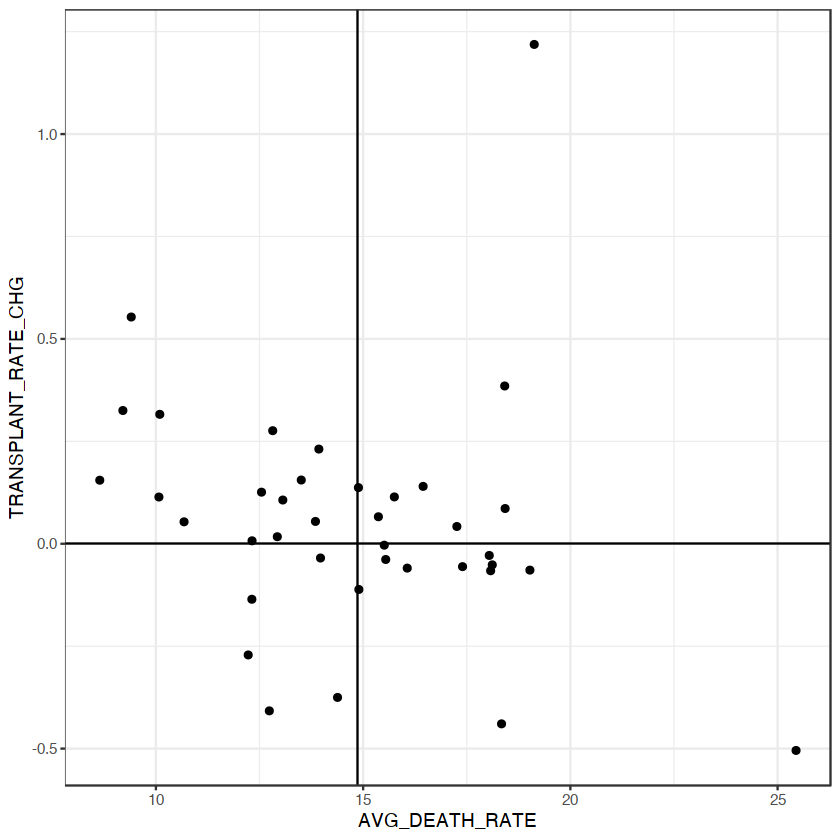

In [20]:
txRateVsDeathRate %>%
    filter(!is.na(TRANSPLANT_RATE_CHG)) %>%
    count(WORSE_50PCT_DEATH_RATE_STATE = AVG_DEATH_RATE >= 14.86813,
          TRANSPLANT_RATE_WORSENED = TRANSPLANT_RATE_CHG <= 0)

txRateVsDeathRate %>%
    filter(!is.na(TRANSPLANT_RATE_CHG)) %>%
    ggplot(aes(x = AVG_DEATH_RATE, y = TRANSPLANT_RATE_CHG)) +
    geom_hline(yintercept = 0) +
    geom_vline(xintercept = 14.86813) +
    geom_point() +
    theme_bw()

---

### Analyze per-capita donor rates by region

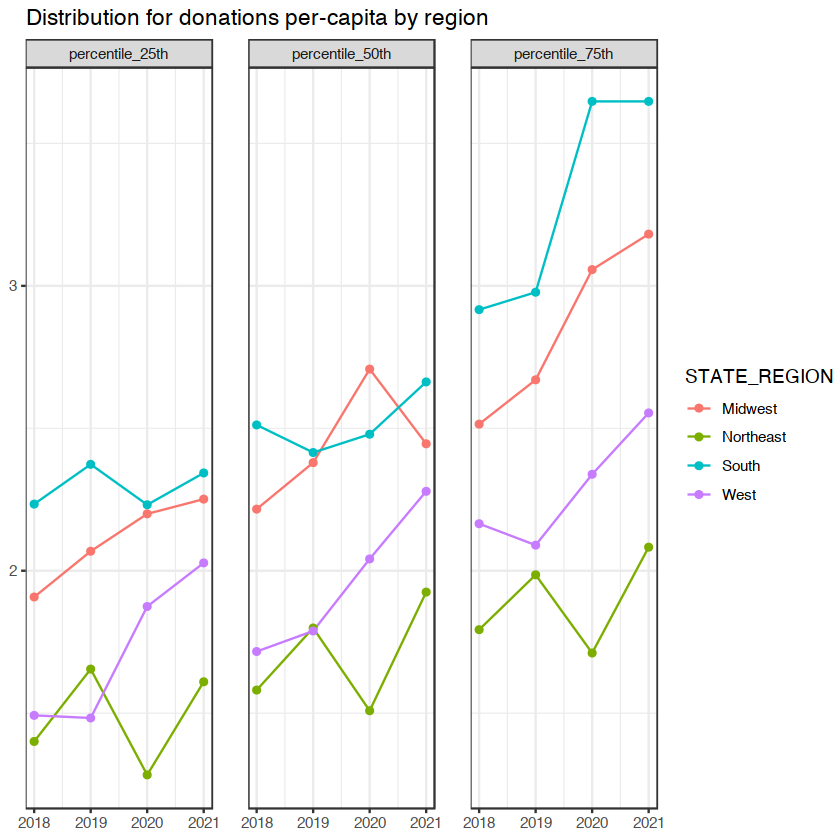

In [21]:
donorRateByRegion.plot <- deathTransplantListingRates %>%
  filter(RACE == "All Races", STATE_NAME != "National") %>%
  left_join(state_code_mapping, by = c("STATE_NAME")) %>%
  group_by(YEAR, STATE_REGION) %>%
  summarise(percentile_25th = quantile(DONOR_RATE, .25),
            percentile_50th = quantile(DONOR_RATE, .50),
            percentile_75th = quantile(DONOR_RATE, .75),
            .groups = "drop") %>%
  pivot_longer(where(is.numeric)) %>%
  ggplot(aes(x = as.numeric(YEAR), y = value, color = STATE_REGION)) +
  geom_line() +
  geom_point() +
  labs(title = "Distribution for donations per-capita by region",
       x = NULL, y = NULL) +
  facet_grid(~ name) +
  theme_bw() +
  theme(panel.spacing.x = unit(1.5, "line"))

ggsave("output/figures/fig2-donor_rates_by_region.png",
       donorRateByRegion.plot, device = "png",
       width = 8, height = 5, unit = "in", dpi = 500)

donorRateByRegion.plot

---

### Analyze transplant vs. donor rates

In [26]:
tx_do_ratio <- transplant %>%
  filter(!is.na(CAN_HOSPITAL_STATE), !is.na(DON_HOSPITAL_STATE)) %>%
  filter(REC_TX_DT_YEAR %in% 2018:2021) %>%
  full_join(x = count(., YEAR = REC_TX_DT_YEAR, STATE = CAN_HOSPITAL_STATE, name = "TX"),
            y = count(., YEAR = REC_TX_DT_YEAR, STATE = DON_HOSPITAL_STATE, name = "DO"),
            by = c("YEAR", "STATE")) %>%
  mutate(across(c("TX", "DO"), replace_na, 0)) %>%
  filter(STATE != "VI") %>%
  bind_rows(group_by(., YEAR, STATE = "US") %>% 
              summarise(across(c("TX", "DO"), sum, na.rm = T),
                        .groups = "drop")) %>%
  mutate(TX_DO_RATIO = TX / DO)

write.csv(x = tx_do_ratio %>% arrange(STATE, YEAR), 
          file = "output/tables/table2-tx_do_ratio_by_state.csv",
          row.names = F)

tx_do_ratio %>% head()

YEAR,STATE,TX,DO,TX_DO_RATIO
<dbl>,<chr>,<int>,<int>,<dbl>
2018,AL,119,125,0.952000
2018,AR,37,50,0.740000
2018,AZ,280,172,1.627907
2018,CA,785,681,1.152717
2018,CO,107,85,1.258824
2018,CT,56,54,1.037037


In [23]:
tx_do_ratio %>% filter(STATE == "AL")

YEAR,STATE,TX,DO,TX_DO_RATIO
<dbl>,<chr>,<int>,<int>,<dbl>
2018,AL,119,125,0.9520000
2019,AL,128,146,0.8767123
2020,AL,97,145,0.6689655
2021,AL,72,168,0.4285714


YEAR,MIN,P10,P25,P50,AVG,P75,P90,MAX
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2019,0.3478261,0.5919688,0.7713189,0.9733333,1.067267,1.217488,1.571781,2.968750
2021,0.2686567,0.4285714,0.6825728,0.9651163,1.096110,1.261491,1.713044,4.192308


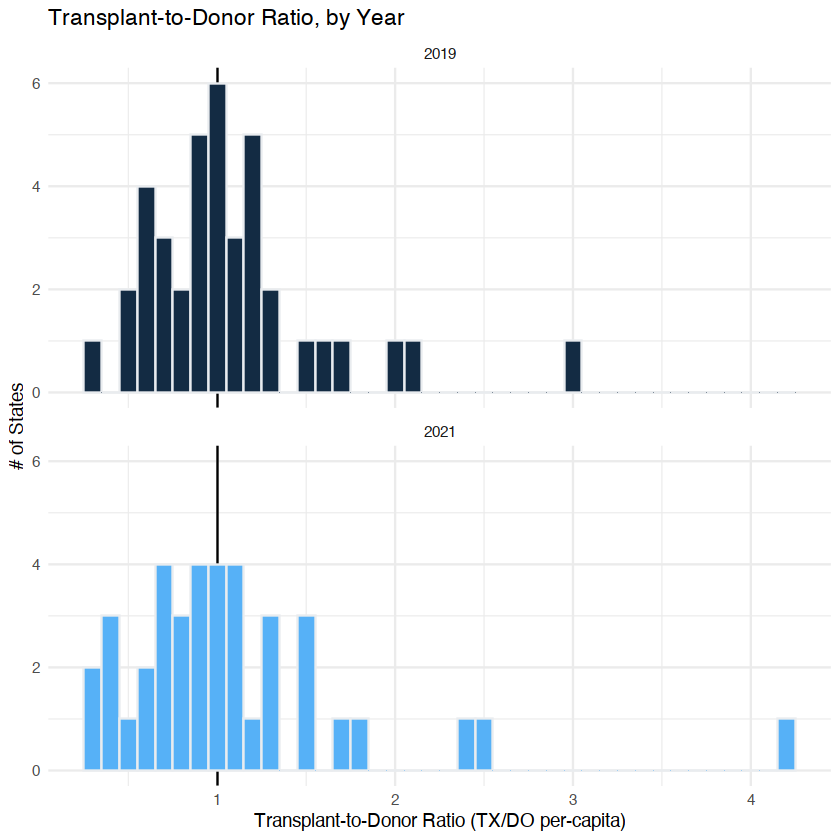

In [24]:
tx_do_ratio %>%
  filter(YEAR %in% c(2019, 2021), TX_DO_RATIO > 0, STATE != "US") %>%
  group_by(YEAR) %>% 
  summarise(MIN = min(TX_DO_RATIO),
            P10 = quantile(TX_DO_RATIO, 0.1),
            P25 = quantile(TX_DO_RATIO, 0.25), 
            P50 = quantile(TX_DO_RATIO, 0.5),
            AVG = mean(TX_DO_RATIO),
            P75 = quantile(TX_DO_RATIO, 0.75),
            P90 = quantile(TX_DO_RATIO, 0.9),
            MAX = max(TX_DO_RATIO))

tx_do_ratio %>%
  filter(YEAR %in% c(2019, 2021), TX_DO_RATIO > 0, STATE != "US") %>%
  ggplot(aes(x = TX_DO_RATIO, fill = YEAR)) +
  geom_vline(xintercept = 1) +
  geom_histogram(color = "#e9ecef", position = 'identity', binwidth = 0.1) +
  facet_wrap(~ YEAR, ncol = 1) +
  labs(x = "Transplant-to-Donor Ratio (TX/DO per-capita)", y = "# of States",
       title = "Transplant-to-Donor Ratio, by Year") +
  theme_minimal() +
  theme(legend.position = "none")

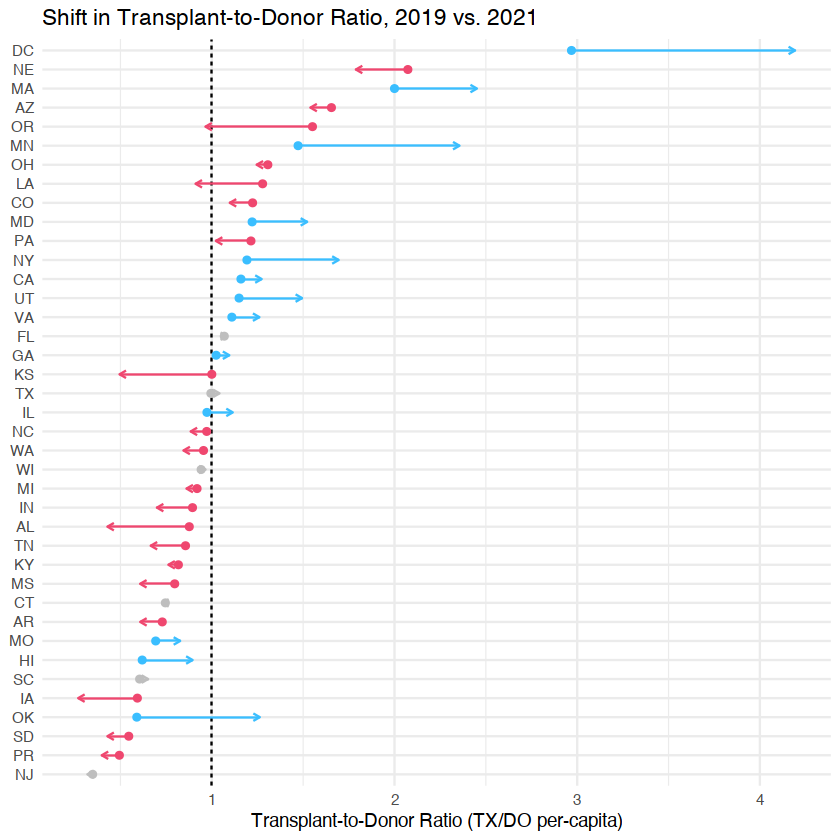

In [25]:
tx_do_ratio %>%
  filter(YEAR %in% c(2019, 2021), STATE != "US") %>%
  pivot_wider(id_cols = STATE, names_from = YEAR, names_prefix = "YR", values_from = TX_DO_RATIO) %>%
  filter(YR2021 > 0, YR2019 > 0) %>%
  mutate(CHG_19to21 = YR2021 - YR2019,
         CHG_GROUP_19to21 = cut(CHG_19to21, c(-Inf, -0.05, 0.05, Inf), 
                                labels = c("Decrease", "Unchanged", "Increase"))) %>%
  arrange(CHG_19to21) %>%
  # count(CHG_GROUP_19to21) %>%
  identity() %>%
  mutate(color = recode(CHG_GROUP_19to21, "Increase" = "#3ABEFF", "Decrease" = "#EF476F", "Unchanged" = "gray")) %>%
  ggplot(aes(x = reorder(STATE, YR2019), color = color)) +
  geom_hline(yintercept = 1, linetype = "dashed") +
  geom_point(aes(y = YR2019)) +
  geom_segment(aes(xend = STATE, y = YR2019, yend = YR2021), na.rm = T,
               arrow = arrow(length = unit(0.01, "npc"))) +
  scale_color_identity() +
  coord_flip() +
  labs(x = NULL, y = "Transplant-to-Donor Ratio (TX/DO per-capita)",
       title = "Shift in Transplant-to-Donor Ratio, 2019 vs. 2021") +
  theme_minimal()